# A Plot of Brownian Noise
<img src="brownian-noise.png" alt="A Plot of Brownian Noise" style="width: 350px; float: right;"/>
This notebook illustrates some of the behaviors of the Singular Value Decomposition of time series data. I've written it in part as a response to [a paper](https://arxiv.org/pdf/1606.07772v2.pdf) by Andrew J. Reagan, Lewis Mitchell, Dilan Kiley, Christopher M. Danforth, and Peter Sheridan Dodds recapitulating an argument first made by [Matt Jockers](http://www.matthewjockers.net/2015/02/25/the-rest-of-the-story/), and critiqued by [Annie Swafford](https://annieswafford.wordpress.com/syuzhet-blog-posts/) and many others: that certain kinds of eigendecompositions of sentiment data from works of fiction will reveal "fundamental plot structures" or "fundamental narrative arcs."

I have doubts about that argument that I [discussed](http://www.lagado.name/blog/sine-of-the-times/) during the [wave](https://storify.com/clancynewyork/contretemps-a-syuzhet) of [debates](https://storify.com/clancynewyork/a-fabula-of-syuzhet-ii) about it last year. Initially, Reagan et. al. seemed to address those doubts. But after going over their paper more carefully, I have come to an even more skeptical conclusion: I think they have actually shown that sentiment time series data from works of fiction is best modeled by a particular kind of noise.

Although I'm making it public now, this notebook is a work in progress, and I would appreciate feedback of any kind, as well as citations to other work that covers similar ground -- which I am sure exists, but haven't yet found.

### Singular Value Decomposition and latent structure

In my initial response to Jockers' work, I emphasized that we had no particular reason to assume that a sinusoidal decomposition would reflect anything meaningful about plot. Until we could justify that assumption, I argued, we could not draw meaningful conclusions from a Fourier transform: we would not know what we were seeing. But Reagan et. al. use a different approach. They take the Singular Value Decomposition (SVD) of sentiment time series data that they extracted from many hundreds of works from Project Gutenberg. Because the SVD places fewer restrictions on the structure of the decomposition that it produces, this approach avoids making the same kinds of assumptions. 

When I saw that the SVD also produces sinusoidal functions from their sentiment time series data, I was startled, and began to reconsider my position on Jockers' original work. It turns out that there really may be a reason to represent sentiment time series data as a sum of sine waves. That reason is given by the [Karhunen-Loève theorem](https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem#The_Wiener_process), which shows that the canonical form taken by the SVD of a particular kind of noise, Brownian noise, is a set of Fourier-like sinusoidal functions.

So using Fourier transforms to smooth sentiment data may be justified after all. But if it is, it's justified because sentiment data behaves like plain, perfectly unpredictable Brownian noise -- that is, noise produced by [random walks](https://en.wikipedia.org/wiki/Random_walk). 

The following code and comments show that many of the results reported in Reagan et. al. can be reproduced simply by transforming Brownian noise. I have not yet reproduced all the results reported in the paper; in particular, I have not tried hierarchical clustering or created a self-organizing map. However, I suspect that the clustering patterns they find will be easy to reproduce with pure noise, and their self-organizing map is difficult to interpret or validate. The most compelling argument they provide for their thesis relies on the way the singular values produced by SVD differ when "word salad" sentiment data is substituted in place of the sentiment data from the original texts. But as I show below, that difference can be replicated simply by rescaling.

Furthermore, there's evidence that if there were fundamental narrative arcs that did not have a purely sinusoidal shape, they would likely be revealed immediately by the SVD. To show this, the code below generates a set of fixed arcs and adds Brownian noise to them. The SVD of the resulting data produces produces complex base shapes that are obviously non-sinusoidal. The fact that no such functions appear among those shown by Reagan et. al. strongly suggests that if there are indeed fundamental narrative arcs, they are almost purely sinusoidal, and have no particular significance except as signs of Brownian noise.

### Global randomness vs. local structure

None of this necessarily means that there are not any fundamental plot structures. Nor does it necessarily mean that there are not other "laws" of plot that we have not yet discovered. It does suggest, however, that by continuing to analyze sentiment time series data this way, we are barking up the wrong tree. The simplest explanation of the sentiment time series findings I've seen so far is that the sentimental arcs of works of fiction are, in general, simply random walks. To produce findings of any additional significance, these methods will need to show phenomena that cannot easily be explained by that model.

On the other hand, the structures of fiction belonging to particular genres, of fiction written at particular times or places, and of fiction created by particular writers or schools of writers may not be modeled by random walks. Moreover, the random walk model might even lead us to _expect_ local regularities at a given scale of analysis. Patterns of imitation and historical influence might be traceable using sentiment analysis. It might even make sense to use Fourier transforms to do the tracing, contrary to what I have [previously argued](http://www.matthewjockers.net/2015/04/06/epilogue/). But the random walk model provides no reason to believe that those patterns will be predictable over the long term, or have any regularities that justify grand generalizations about _Homo Narrativus_. Rather than continuing to look for universal laws where there probably are none, we should start producing historically informed work based on these tools.

# First, a Noise Generator
Generates soothing sounds for baby. (And null hypotheses.)

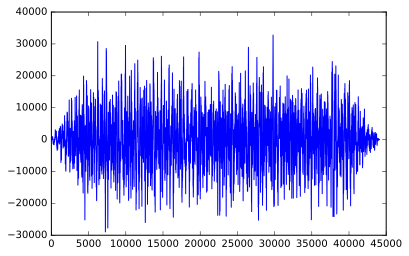

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

import numpy
import scipy
from scipy.io import wavfile
from scipy import signal

class Noise(object):
    def __init__(self, duration=1, sample_rate=44100):
        self.duration = duration
        self.sample_rate = sample_rate
        self.samples = None
        self.resample()
        
    @property
    def n_samples(self):
        return int(self.duration * self.sample_rate)

    def resample(self, amplitude=1):
        """Take a series of random samples from a gaussian distribution."""
        samples = numpy.random.normal(-1, 1, self.n_samples)
        samples -= samples.mean()
        self.samples = samples
    
    def integrate(self):
        """'Integrate' (i.e. do a cumulative sum of) the current sample set.
        This is useful because integrating white noise produces Brownian
        noise. 
        
        There's a wonderfully concrete way to understand that fact. Imagine 
        you're a particle that wiggles, and that each time you move, you 
        decide how to move by taking a sample from a Gaussian distribution. 
        If you plotted all your movements by starting from zero each time,
        you'd get a white noise (Gaussian noise) pattern. But if you plotted
        the resulting path, you'd get a Brownian noise pattern. The
        resulting path is just the sum of the individual movements; hence
        integrating (summing) white noise produces Brownian noise.
        """
        self.samples[:] = self.samples.cumsum()
        self.samples -= self.samples.mean()
        return self
    
    def butter_high(self, freq=2 ** -8, order=1):
        b, a = signal.butter(order, freq, 'high', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self

    def butter_low(self, freq=2 ** -1, order=1):
        b, a = signal.butter(order, freq, 'low', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self
    
    def butter_filter(self, lowpass=2 ** -1, highpass=2 ** -8, order=1):
        """Perform a high- and low-pass butterworth filter."""
        self.butter_low(lowpass, order)
        self.butter_high(highpass, order)
        return self

    def gauss_filter(self, sample_width=0.002):
        """Convolve with a unit area Gaussian kernel. This is the 
        same thing as a weighted moving average with a Gaussian 
        weight curve.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def square_filter(self, sample_width=0.002):
        """Convolve with a unit area constant kernel. This is the 
        same thing as an unweighted moving average.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def fade(self, sample_width=0.1):
        """Fade in at the beginning and out at the end. This softens the
        percieved 'click' at the beginning and end of the noise.
        """
        sample_width = int(self.sample_rate * sample_width)
        self.samples[:sample_width] *= numpy.linspace(0, 1, sample_width)
        self.samples[-sample_width:] *= numpy.linspace(1, 0, sample_width)
        return self

    def scale(self):
        """Scale the current data by the absolute maximum. This maximizes
        volume without causing clipping artifacts.
        """
        self.samples -= self.samples.mean()
        self.samples /= numpy.max(numpy.abs(self.samples))
        self.samples *= 32767  # max amplitude at 16 bits per sample
        return self
        
    def amplify(self, amplitude=1):
        """Amplify the tone by the given amplitude. This may produce clipping."""
        self.samples *= self.amplitude
        return self
    
    def wav(self):
        """Return data suitable for saving as a PCM or .wav file."""
        return numpy.int16(self.samples)
    
    def _mk_sample(self, amplitude=1, filtered=False, faded=False, brownian=False,
                   gaussfilter=False, squarefilter=False, sample_width=0.002):
        self.resample(amplitude)
        self.integrate() if brownian else None
        self.gauss_filter(sample_width) if gaussfilter else None
        self.square_filter(sample_width) if squarefilter else None
        self.butter_filter(order=5) if filtered else None
        self.fade() if faded else None
        self.scale()
        return self
    
    def brownian(self, amplitude=1, filtered=False, faded=False):
        """Convenience method for generating Brownian noise."""
        return self._mk_sample(amplitude, filtered, faded, brownian=True)
    
    def brownian_gaussfilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Conveninence method for generating Brownian noise
        passed through a gaussian filter. This produces
        especially soothing 'white' noise.
        """
        return self._mk_sample(amplitude, filtered, faded, brownian=True, 
                               gaussfilter=True, sample_width=sample_width)
    
    def brownian_squarefilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience method for generating Brownian noise passed
        through a square filter.
        """
        return self._mk_sample(amplitude, filtered, faded, brownian=True, 
                               squarefilter=True, sample_width=sample_width)

    def white(self, amplitude=1, filtered=False, faded=False):
        """Convenience method for generating white noise."""
        return self._mk_sample(amplitude, filtered, faded)
    
    def white_gaussfilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience method for generating white noise passed
        through a gaussian filter.
        """
        return self._mk_sample(amplitude, filtered, faded, gaussfilter=True, 
                               sample_width=sample_width)

    def white_squarefilter(self, amplitude=1, filtered=False, faded=False, sample_width=0.002):
        """Convenience function for generating white noise passed
        through a square filter.
        """
        return self._mk_sample(amplitude, filtered, faded, squarefilter=True, 
                               sample_width=sample_width)

    
noise = Noise(duration=1)
noise.brownian(filtered=True, faded=True)
plt.plot(noise.wav())
plt.show()
#wavfile.write('test.wav', noise.sample_rate, noise.wav())

This is somewhat filtered, so that the sound is easier to hear. (Yes, this literally generates sound. Uncomment the last line above to save a `.wav` file.)

Now for some unfiltered noise...

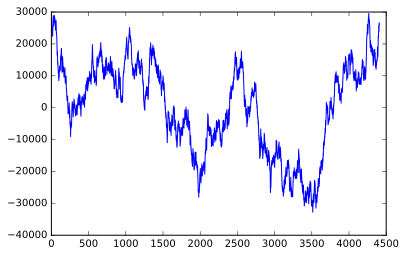

In [2]:
noise = Noise(duration=0.1)
samples = numpy.hstack([noise.brownian().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

# Create the SVD

Now we can perform Singular Value Decomposition on the samples generated above. The shape of the basis vector functions is not predetermined; if you pass in white noise, they also look like white noise. But if you pass in Brownian noise, they look just like the basis functions of a Fourier transform. The basis functions are guaranteed to produce the best approximation of the input, even when truncated; that's the essence of the Karhunen-Loève theorem.

In [3]:
U, s, V = numpy.linalg.svd(samples, full_matrices=False)

Let's also verify that the SVD operation has produced reasonable results. Then we can start plotting eigenfunctions.

In [4]:
numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

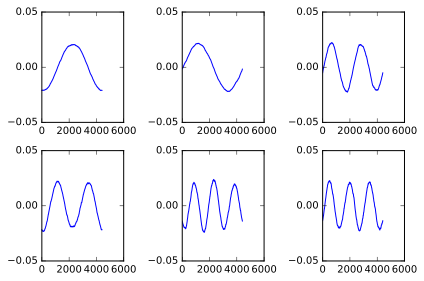

In [5]:
xbins = 3
ybins = 3
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

Here are a few of the most significant basis functions. They 
might be a little off -- frequently they are not centered in 
the way one might expect. But they consistently look like 
sinusoidal curves with increasing frequencies, maybe with
a bit of peach fuzz.

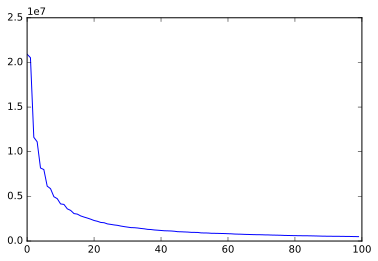

In [6]:
plt.plot(s[0:100])
plt.show()

The above plot indicates how significant each of the basis functions
are. As you can see, their significance drops off exponentially.

Note that the rate of drop-off can be modified by increasing or decreasing
the overall power of the noise. To produce basis fuctions with lower
singular values, just reduce the amplitude. Here's a version of the 
above plot based on a muted version of the same data.

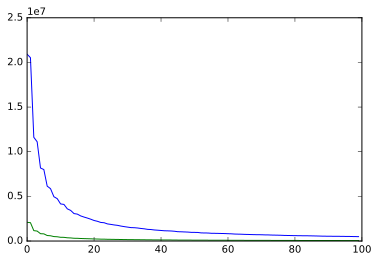

In [7]:
samples_low = samples / 10
U_low, s_low, V_low = numpy.linalg.svd(samples_low, full_matrices=False)
plt.plot(s[0:100])
plt.plot(s_low[0:100])
plt.show()

So the difference that Reagan et. al. argue indicates 
"less important ordering of the singular vectors" can be 
reproduced just by rescaling the data.

# Other Noise

When you perform SVD on white noise, the basis functions are just more white noise.

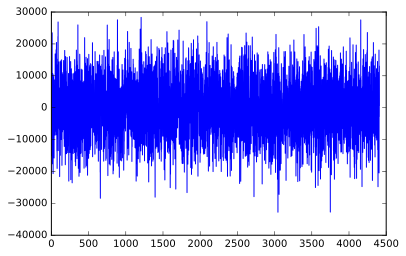

In [8]:
noise = Noise(duration=0.1)
samples = numpy.hstack([noise.white().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

In [9]:
U, s, V = numpy.linalg.svd(samples, full_matrices=False)
numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

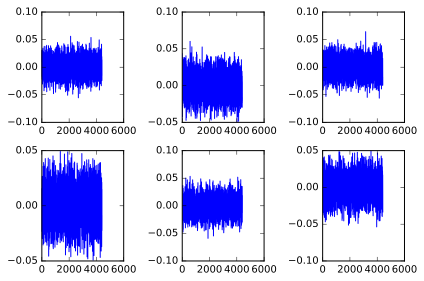

In [10]:
xbins = 3
ybins = 5
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

No more curvy eigenfunctions -- just static.

And notice that the power spectrum is basically flat. It goes
down a bit because of aliasing effects (I think). Still, the 
minimum value is only 10% lower than the maximum value:

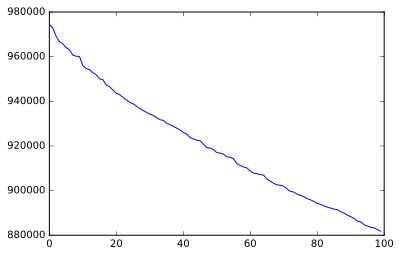

In [11]:
plt.plot(s[0:100])
plt.show()

# Simulating Fundamental Arcs

We've seen that the SVD creates sinusoidal eigenfunctions
when we use Brownian noise, and random eigenfunctions when we
use white noise. What about when we use a mixture of 
deterministic functions and brownian noise? Let's start
by creating some random base modes:

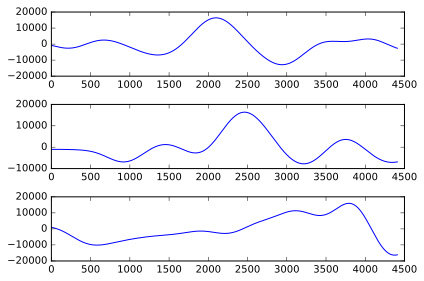

In [12]:
base_modes = [noise.white_squarefilter(sample_width=0.05).wav().reshape(-1, 1) / 2
              for x in range(3)]
xbins = 10
ybins = 5
plt.subplot(3, 1, 1)
plt.plot(base_modes[0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(base_modes[1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(base_modes[2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

These are white noise signals filtered with a square filter,
which helps to ensure that there will be some non-sinusoidal
structure.

Now we produce our signals by picking a random base mode for
each instance and adding some Brownian noise:

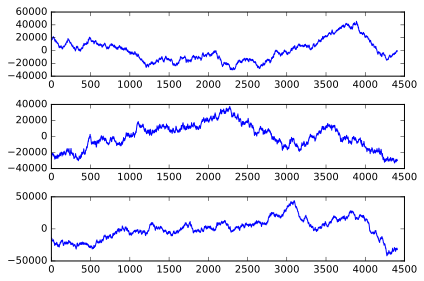

In [13]:
selector = numpy.random.random(len(base_modes[0])) * 3
selector = selector.astype('int')
modes = [base_modes[x] for x in selector]
fixed_arcs = [noise.brownian().wav().reshape(-1, 1) + mode 
              for x, mode in zip(range(2000), modes)]

fixed_arcs = numpy.hstack(fixed_arcs)

plt.subplot(3, 1, 1)
plt.plot(fixed_arcs[:,0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(fixed_arcs[:,1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(fixed_arcs[:,2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

It's hard to tell the difference between this and 
plain old Brownian noise, right? But the SVD
gets it right away.

In [14]:
U, s, V = numpy.linalg.svd(fixed_arcs, full_matrices=False)
numpy.allclose(fixed_arcs, U @ numpy.diag(s) @ V)

True

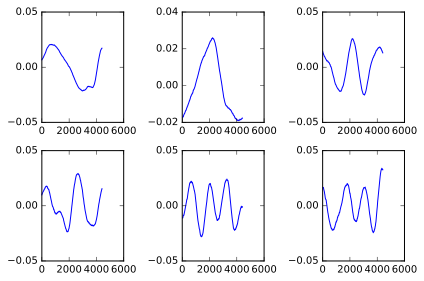

In [15]:
nbins = 3
plt.subplot(2, 3, 1)
plt.plot(U[:,0].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 2)
plt.plot(U[:,1].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 3)
plt.plot(U[:,2].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 4)
plt.plot(U[:,3].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 5)
plt.plot(U[:,4].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 6)
plt.plot(U[:,5].reshape(-1))
plt.locator_params(nbins=nbins)
plt.tight_layout()
plt.show()

These still have a quasi-sinusoidal character, but they diverge
noticably from the neat, clean curves generated by pure Brownian 
noise -- and by the data in Reagan, et. al.

# An Afterword
<img src="portrait_no_last_third1.png" alt="A sentiment plot of Joyce's Portrat of the Artist as a Young Man with the last third flattened." style="width: 350px; float: right;"/>
One of the most intersesting parts of last year's Swafford-Jockers debate was their discussion of ringing artifacts. Swafford came up with an [ingenius way](https://annieswafford.wordpress.com/2015/03/07/continuingsyuzhet/) to show that the Fourier transform was creating distortions that were not justified by the data: she flattened the last third of a book's sentiment data, and found that the Fourier transform that resulted was nearly identical. Clearly the Fourier transform was imposing a bias that had distorted the data significantly.

Jockers' response was [equally ingenius](http://www.matthewjockers.net/2015/03/24/ringing_endorsement/). He argued that the distortion was desirable -- that the assumptions it arose from were actually recreating information about the book that had been removed. But at that point, the discussion reached a standstill, because there was no way to validate Jockers' claim. We had no good reason to assume that the sinusoidal basis functions were capturing anything particularly true about the novel.

Together with the random walk model, the Karhunen-Loève theorem gives us a very good reason. During the initial debate, I found Jockers' response to Swafford at least partially persuasive, because the test data that Swafford created just looks... wrong. And if sentiment time series are produced by random walks, then it really is wrong -- a flat line like that is, for all intents and purposes, impossible to generate with a random walk.

What's exciting is that the Karhunen-Loève (KL) theorem gives us a way to validate that claim. The theorem states that the KL decomposition of time series data produces basis functions that give the best possible approximation of that data, as measured by mean square error. And it's readily apparent that the Fourier transform of Swafford's data is a _terrible_ approximation of it. That was the whole basis of Swafford's argument. 

On that same basis, given the KL theorem, we should expect the decomposition of data that has lots of Swafford artifacts to be non-sinusoidal. 

And indeed it is:

In [16]:
swafford_samples = numpy.hstack([noise.brownian().wav().reshape(-1, 1) 
                        for x in range(2000)])

swafford_samples[-swafford_samples.shape[0] // 3:, 
                 :swafford_samples.shape[1] // 2] = 0

In [17]:
U_sw, s_sw, V_sw = numpy.linalg.svd(swafford_samples, full_matrices=False)
numpy.allclose(swafford_samples, U_sw @ numpy.diag(s_sw) @ V_sw)

True

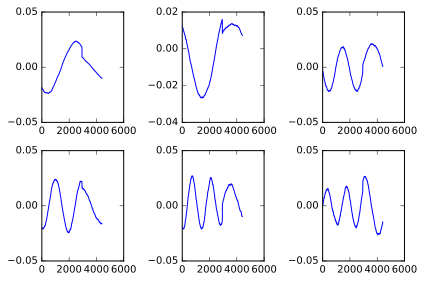

In [18]:
nbins = 3
plt.subplot(2, 3, 1)
plt.plot(U_sw[:,0].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 2)
plt.plot(U_sw[:,1].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 3)
plt.plot(U_sw[:,2].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 4)
plt.plot(U_sw[:,3].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 5)
plt.plot(U_sw[:,4].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 6)
plt.plot(U_sw[:,5].reshape(-1))
plt.locator_params(nbins=nbins)
plt.tight_layout()
plt.show()

The effect is subtle but immediately noticable. At the same point in every graph, two-thirds of the way through, there's a sudden jump upwards or downwards. In some cases it's more noticable than in others, but it's always there. And it means that this decomposition is far better at approximating Swafford artifacts:

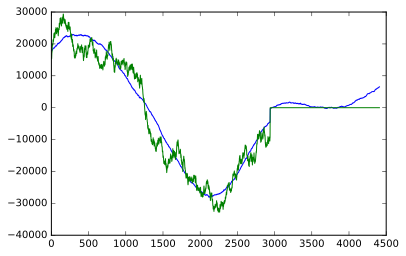

In [19]:
approx = U_sw[:,0:6] @ numpy.diag(s_sw[0:6]) @ V_sw[0:6,:]
plt.plot(approx[:,0])
plt.plot(swafford_samples[:,0])
plt.show()

This suggests that Swafford's test isn't the right one for evaluating the Fourier 
transform as a smoothing strategy.

Still, even though that limits the force of Swafford's critique on this narrow point, it 
reaffirms her fundamental argument. If we accept the utility of the Fourier transform for sentiment 
analysis, then we are essentially _assuming_ that our data has been generated by random walks, and 
that all other generalizations must be rejected out of hand. We can have grand generalizations 
or Fourier transforms, but not both.

To argue otherwise, it would be necessary to do one of two things. 

The first would be to find a plausible model of writing that generates time series data with 
the same distinctly Fourier-like SVD, but that is not effectively random. I can't say with 
certainty that such a thing is impossible, because there's [no general procedure](https://en.wikipedia.org/wiki/Kolmogorov_complexity#Chaitin.27s_incompleteness_theorem) 
that can always tell whether a sequence of values is truly random and incompressible. But such 
pseudo-random models are unlikely to be psychologically plausible models of writing.

The second would be to use extraordinarily careful experimental methods to show that the 
SVD of sentiment time series data isn't really Fourier-like after all. And maybe it isn't; 
maybe the results that Reagan, et. al. report are only superficially Fourier-like. But 
demonstrating that will require far more research and study than we've done so far.